# Imports

In [32]:
%pylab inline
from functools import partial
from tqdm import tqdm
import pickle
from chainconsumer import ChainConsumer

import jax
import jax.numpy as jnp

import tensorflow_probability as tfp
tfp = tfp.substrates.jax
tfd= tfp.distributions
tfb = tfp.bijectors

import tensorflow_datasets as tfds
import tensorflow as tf

import haiku as hk
from haiku._src.nets.resnet import ResNet18
import optax
from flax.metrics import tensorboard

from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP
from sbids.tasks.lensinglognormal import lensingLogNormal

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [33]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [34]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Dataset

In [5]:
# # # already load datasets but if not run this cell

# from sbids.datasets import LensingLogNormalDataset

# ds = tfds.load('LensingLogNormalDataset/toy_model_with_proposal_with_noise', 
#                split='train', 
#                data_dir = 'tensorflow_dataset')

# Pre trained compressor

In [35]:
# create nf to train using mutual information
bijector_layers_compressor = [128] * 2

bijector_compressor = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers_compressor, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_compressor = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_compressor)

class Flow_nd_Compressor(hk.Module):
    def __call__(self, y):
        nvp = NF_compressor(2)(y)
        return nvp

nf = hk.without_apply_rng(hk.transform(lambda theta, y : Flow_nd_Compressor()(y).log_prob(theta).squeeze()))
params_nf = nf.init(jax.random.PRNGKey(8),  0.5*jnp.ones([1,2]), 0.5*jnp.ones([1,2]))

# ResNet 18
compressor = hk.transform_with_state(lambda x : ResNet18(2)(x, is_training=True))
parameters_resnet, opt_state_resnet  = compressor.init(jax.random.PRNGKey(873457568), 0.5*jnp.ones([1,128,128,1]))

parameters_compressor = hk.data_structures.merge(parameters_resnet, params_nf)

In [36]:
# load compressor params

a_file = open("data/params_nd_compressor_mse_LensingLogNormal_with_augggg_lr.pkl", "rb")
parameters_compressor = pickle.load(a_file)

a_file = open("data/opt_state_resnet_mse_with_augggg_lr.pkl", "rb")
opt_state_resnet= pickle.load(a_file)

# SBI

## Create NF for SBI

In [37]:
bijector_layers = [128] * 2

bijector_npe = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_npe = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_npe)

prior = tfd.MultivariateNormalDiag(jnp.array([0.3,0.8]), 0.05*jnp.ones(2))
theta = prior.sample(10000,jax.random.PRNGKey(0))
scale_theta = (jnp.std(theta, axis = 0)/0.06)
shift_theta = jnp.mean(theta/scale_theta, axis = 0)-0.5

class SmoothNPE(hk.Module):
    def __call__(self, y):
        net = y
        nvp = NF_npe(2)(net)
        return tfd.TransformedDistribution(nvp,
                                           tfb.Chain([tfb.Scale(scale_theta),
                                                      tfb.Shift(shift_theta)]))

nvp_nd = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).log_prob(theta).squeeze()))

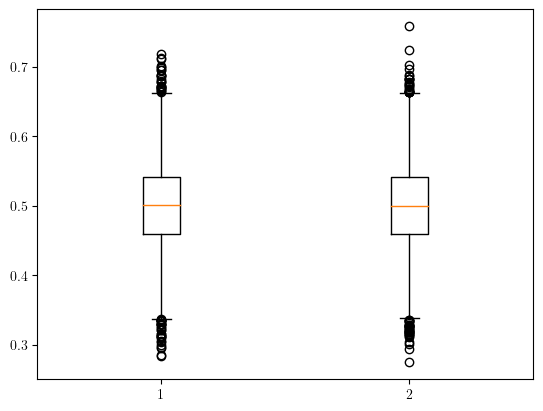

In [41]:
normalized_p = tfb.Chain([tfb.Scale(scale_theta),tfb.Shift(shift_theta)]).inverse(theta)
plt.boxplot([normalized_p[...,0],
             normalized_p[...,1],

             ]);

## Training

In [26]:
# apt loss from https://github.com/mackelab/sbi/blob/main/sbi/inference/snpe/snpe_c.py
# https://arxiv.org/pdf/1905.07488.pdf

import torch 

def loss_apt(
    params, 
    parameters_compressor, 
    opt_state_resnet, 
    weight, 
    mu, 
    batch, 
    score
):
        
        y, _ = compressor.apply(
            parameters_compressor,
            opt_state_resnet,
            None, 
            batch.reshape([-1,128,128,1])
        )
        _, out = jax.vmap(
            jax.value_and_grad(lambda theta, x: nvp_nd.apply(params, theta.reshape([1,2]), x.reshape([1,2])).squeeze())
            )(mu, y)
        score_matching_loss = jnp.mean(jnp.sum((out - score)**2, axis=1))
        
        num_atoms = 128
        batch_size = len(mu)
        # Each set of parameter atoms is evaluated using the same x,
        # so we repeat rows of the data x, e.g. [1, 2] -> [1, 1, 2, 2]
        repeat_y = jnp.repeat(y, num_atoms, axis = 0)
        
        # To generate the full set of atoms for a given item in the batch,
        # we sample without replacement num_atoms - 1 times from the rest
        # of the theta in the batch.
        probs = torch.ones(batch_size, batch_size) * (1 - torch.eye(batch_size)) / (batch_size - 1)

        choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)
        choices = jnp.array(choices)
        
#         mu = torch.Tensor(mu)
        contrasting_theta = jnp.array(mu[choices])

        # We can now create our sets of atoms from the contrasting parameter sets
        # we have generated.
        atomic_theta = jnp.concatenate([mu[:, None, :], contrasting_theta], axis=1).reshape(
            batch_size * num_atoms, -1
        )
        # Evaluate large batch giving (batch_size * num_atoms) log prob posterior evals.
#         log_prob_posterior, _ = jax.vmap(
#           jax.value_and_grad(lambda theta, x: nvp_nd.apply(
#               params, 
#               theta.reshape([1,2]), 
#               x.reshape([1,2])).squeeze()
#            )
#         )(jnp.array(atomic_theta), repeat_y)
        log_prob_posterior = nvp_nd.apply(
            params, 
            jnp.array(atomic_theta), 
            repeat_y
        )
        log_prob_posterior = log_prob_posterior.reshape([batch_size, num_atoms])

        # Get (batch_size * num_atoms) log prob prior evals.
        prior = tfd.MultivariateNormalDiag(
          loc = jnp.array([0.3,0.8]),
          scale_diag = 0.05 * jnp.ones(2)
        )
        log_prob_prior = prior.log_prob(atomic_theta)
        log_prob_prior = log_prob_prior.reshape(batch_size, num_atoms)

        # Compute unnormalized proposal posterior.
        unnormalized_log_prob = log_prob_posterior - log_prob_prior

        # Normalize proposal posterior across discrete set of atoms.
        log_prob_proposal_posterior = unnormalized_log_prob[:, 0] - tfp.math.reduce_weighted_logsumexp(unnormalized_log_prob, axis=-1)
            
        return -jnp.mean(log_prob_proposal_posterior) + weight * score_matching_loss

    
def loss_sm(
    params, 
    parameters_compressor, 
    opt_state_resnet, 
    weight, 
    mu, 
    batch, 
    score
):
        
        y, _ = compressor.apply(
            parameters_compressor,
            opt_state_resnet,
            None, 
            batch.reshape([-1,128,128,1])
        )
        _, out = jax.vmap(
            jax.value_and_grad(lambda theta, x: nvp_nd.apply(params, theta.reshape([1,2]), x.reshape([1,2])).squeeze())
            )(mu, y)
        score_matching_loss = jnp.mean(jnp.sum((out - score)**2, axis=1))

        return weight * score_matching_loss

In [27]:
@jax.jit
def update(params, parameters_compressor, opt_state, opt_state_resnet, weight, mu, batch, score):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_apt)(
        params,
        parameters_compressor, 
        opt_state_resnet, 
        weight, 
        mu,
        batch, 
        score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [9]:
%load_ext tensorboard
%tensorboard --logdir=.

In [29]:
summary_writer = tensorboard.SummaryWriter('train/sbi_apt_score_11')
nvp_nd = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).log_prob(theta).squeeze()))
params_nd = nvp_nd.init(jax.random.PRNGKey(42), 0.5*jnp.ones([1,2]), 0.5*jnp.ones([1,2]))
score_weight = 0
nb_simulations = 100000

ds = tfds.load('LensingLogNormalDataset/toy_model_with_proposal_with_noise', 
               split='train[:{}]'.format(nb_simulations), 
               data_dir = 'tensorflow_dataset')

ds = ds.repeat()
ds = ds.shuffle(1000)
ds = ds.batch(128)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds))

#optimizer
total_steps = 1000
lr_scheduler = optax.piecewise_constant_schedule(init_value=0.001,
                  boundaries_and_scales={int(total_steps*0.1):0.7,
                                         int(total_steps*0.2):0.7,
                                         int(total_steps*0.3):0.7,
                                         int(total_steps*0.4):0.7,
                                         int(total_steps*0.5):0.7,
                                         int(total_steps*0.6):0.7,
                                         int(total_steps*0.7):0.7,
                                         int(total_steps*0.8):0.7,
                                         int(total_steps*0.9):0.7})

# optimizer = optax.chain(
#   optax.adaptive_grad_clip(1.0, eps=0.001),
#   optax.adam(learning_rate=lr_scheduler),
# )
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state = optimizer.init(params_nd)
for batch in tqdm(range(total_steps)):
    sample = next(ds_train)
    l, params_nd, opt_state = update(
        params_nd, 
        parameters_compressor, 
        opt_state, 
        opt_state_resnet,
        score_weight, 
        sample['theta'], 
        sample['simulation'], 
        sample['score']
    )
    
    if jnp.isnan(l):
        break 
           
    if batch % 100:
        summary_writer.scalar('train_loss', l, batch)
        summary_writer.scalar('lr', lr_scheduler(batch), batch)
        params_nd_tmp = params_nd 

  0%|          | 0/1000 [00:00<?, ?it/s]/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
2023-03-16 17:22:03.331251: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:751] None of the al

## Create fiducial and plot results

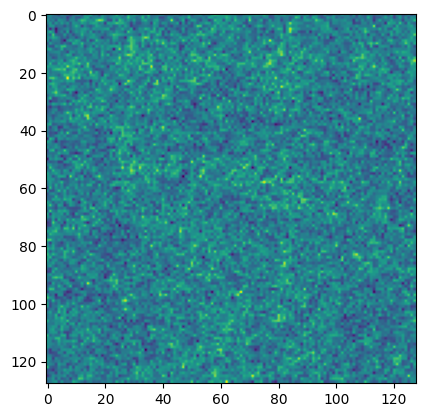

In [14]:
truth = jnp.array([0.3, 0.8])
m_data = jnp.load('data/m_data_lensing.npy')
imshow(m_data)

In [15]:
# reference posterior
sample_power_spectrum = np.load('data/sample_power_spectrum_toy_model.npy')
sample_full_field = np.load('data/sample_full_field.npy')

In [30]:
y, _ = compressor.apply(
    parameters_compressor, opt_state_resnet, None, m_data.reshape([1,128,128,1])
)
nvp_sample_nd = hk.transform(
    lambda x : SmoothNPE()(x).sample(len(sample_full_field), seed=hk.next_rng_key())
)
sample_nd = nvp_sample_nd.apply(
    params_nd_tmp, 
    rng = jax.random.PRNGKey(43), 
    x = y*jnp.ones([len(sample_full_field),2])
)

/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)


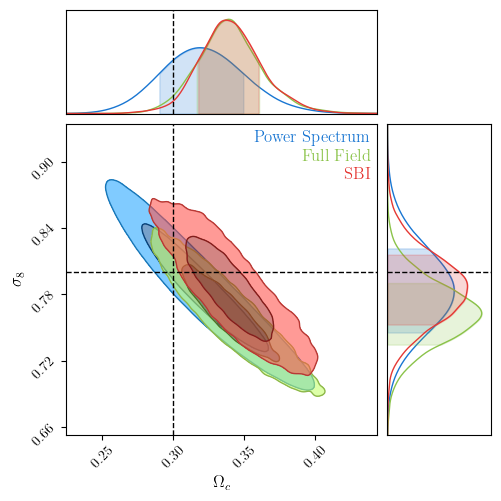

In [16]:
# without score
c = ChainConsumer()
c.add_chain(sample_power_spectrum, parameters=["$\Omega_c$", "$\sigma_8$"], name='Power Spectrum')
c.add_chain(sample_full_field, parameters=["$\Omega_c$", "$\sigma_8$"], name='Full Field')
c.add_chain(sample_nd, parameters=["$\Omega_c$", "$\sigma_8$"], name='SBI')
fig = c.plotter.plot(figsize="column", truth = [0.3,0.8])